In [1]:
%run data_utils.py

In [2]:
PATH = 'storage'
ARTIST = "*"
REP = 1

NOTES_WINDOW = 8
CHORDS_WINDOW = 3
PITCHES_PER_CHORD = 4
MODE = "pitches"

MIN_FREQ = 5 * REP
UNKNOWN = "UNK"

VALIDATION_SIZE = 0.1

data = get_parsed_data(PATH)
chords_mapping = get_chords_mapping(PATH)

TEST_SELECT = select_test(data, PATH)
TRAIN_SELECT = select_train(data, artist=ARTIST, test_select=TEST_SELECT)

TRAIN_SONGS, notes_translated, chords_translated = select_songs(data, TRAIN_SELECT, REPEAT=1)
TEST_SONGS, notes_translated_test, chords_translated_test = select_songs(data, TEST_SELECT, REPEAT=1)
print(len(TRAIN_SONGS), len(TEST_SONGS))

Loaded TEST indices
12149 1317


In [3]:
chords_mapping["C major triad"]

'C+E+G'

In [ ]:
X_train_n_raw, X_train_ch_raw, y_train_raw, is_start_train, row_to_song_idx_train = prepare_raw_X_y(
    notes_translated, 
    chords_translated,
    notes_window=NOTES_WINDOW,
    chords_window=CHORDS_WINDOW,
    use_next_chord=True,
    rep=REP
)
y_train_raw_pitches, y_train_raw_durations = _split_notes(y_train_raw)

print("num samples:", len(X_train_n_raw))
print("nunique y pitches:", len(set(y_train_raw_pitches)))
print("nunique y durations:", len(set(y_train_raw_durations)))

y_train_raw_pitches, y_train_raw_durations = trim_rare_labels_separately(
    y_train_raw_pitches, y_train_raw_durations, 
    min_freq=MIN_FREQ, 
    unk=UNKNOWN
)
print("\nafter filtering:")
print("nunique y pitches:", len(set(y_train_raw_pitches)))
print("nunique y durations:",len(set(y_train_raw_durations)))

In [ ]:
print("MODE:", MODE)
X_train, indices_cache = prepare_input_X(
    X_train_n_raw, 
    X_train_ch_raw, 
    is_start_train, 
    row_to_song_idx_train, 
    mode=MODE,
    notes_window=NOTES_WINDOW, 
    chords_window=CHORDS_WINDOW,
    chord_size=PITCHES_PER_CHORD,
    chords_mapping=chords_mapping
)
print('cache:', len(indices_cache))
print()

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train_pitches, token_to_id_pitches = prepare_input_y(y_train_raw_pitches)
y_train_durations, token_to_id_durations = prepare_input_y(y_train_raw_durations)

id_to_token_pitches = {token_to_id_pitches[token] : token for token in token_to_id_pitches}
id_to_token_durations = {token_to_id_durations[token] : token for token in token_to_id_durations}

print("pitches:", y_train_pitches.shape)
print("durations:", y_train_durations.shape)

In [6]:
Counter(y_train_raw_pitches).most_common(10)

[('E5', 1106),
 ('C5', 969),
 ('A5', 921),
 ('D5', 880),
 ('B4', 857),
 ('A4', 799),
 ('C6', 779),
 ('B5', 766),
 ('G5', 658),
 ('REST', 592)]

In [7]:
Counter(y_train_raw_durations).most_common(10)

[('0.5', 5434),
 ('1.0', 2174),
 ('0.25', 1838),
 ('0.75', 729),
 ('1.5', 617),
 ('2.0', 564),
 ('4.0', 182),
 ('3.0', 156),
 ('2.5', 93),
 ('3.5', 48)]

In [8]:
from sklearn.model_selection import train_test_split

song_idx_list = list(set(row_to_song_idx_train))
train_idx_list, validation_idx_list = train_test_split(song_idx_list, train_size=1-VALIDATION_SIZE, test_size=VALIDATION_SIZE, random_state=20202208)   

print("# TRAIN SONGS:", len(train_idx_list))
print("# VALIDATION SONGS:", len(validation_idx_list))

from sklearn.preprocessing import MinMaxScaler
print(" >>> Scaling data!")
MINMAX_SCALE = (-1, 1)
scaler = MinMaxScaler(feature_range=MINMAX_SCALE)
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], X_train.shape[1]))
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, -1)

batch_input_shape = (1, 1, X_train.shape[1])
num_pitches = y_train_pitches.shape[-1]
num_durations = y_train_durations.shape[-1]

# TRAIN SONGS: 198
# VALIDATION SONGS: 22
 >>> Scaling data!


In [9]:
%run models.py

SEED: 13111996
python 3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
keras version 2.4.0
tensorflow version 2.3.0


storage/models/pitches/LSTM-NEW-128-128_zun


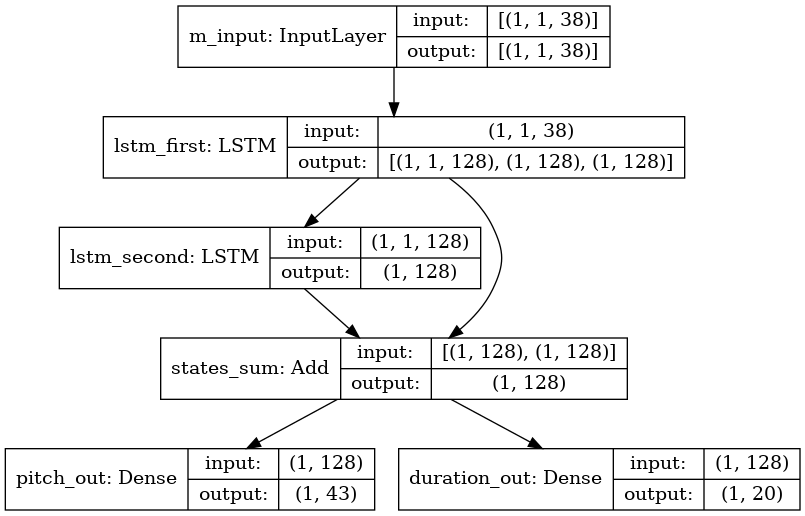

In [10]:
cum_loss=0
best_loss=float('inf')
loss_per_epoch = {"train": {"all": [], "p": [], "d": []}, "val": {"all": [], "p": [], "d": []}}
learning_rates = []

LSTM_SIZE = 128
LSTM_SIZE2 = 128

LEARNING_RATE = 1e-5

# model, opt, model_name = get_stateful_lstm_multi_output(batch_input_shape, num_pitches, num_durations, LSTM_SIZE, lr=LEARNING_RATE)
model, opt, model_name = get_stateful_lstm_multi_output_deeper_NEW(batch_input_shape, num_pitches, num_durations, LSTM_SIZE, LSTM_SIZE2, lr=LEARNING_RATE)

model_name += f"_{ARTIST}"
model_dir = os.path.join(PATH, "models", MODE, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

print(model_dir)

from keras.utils import plot_model
plot_model(model, os.path.join(model_dir, f"{model_name}.png"), show_shapes=False)
plot_model(model, os.path.join(model_dir, f"{model_name}_shapes.png"), show_shapes=True)


In [11]:
with open(os.path.join(model_dir, model_name + "_model.txt"),'w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m_input (InputLayer)            [(1, 1, 38)]         0                                            
__________________________________________________________________________________________________
lstm_first (LSTM)               [(1, 1, 128), (1, 12 85504       m_input[0][0]                    
__________________________________________________________________________________________________
lstm_second (LSTM)              (1, 128)             131584      lstm_first[0][0]                 
__________________________________________________________________________________________________
states_sum (Add)                (1, 128)             0           lstm_first[0][1]                 
                                                                 lstm_second[0][0]     

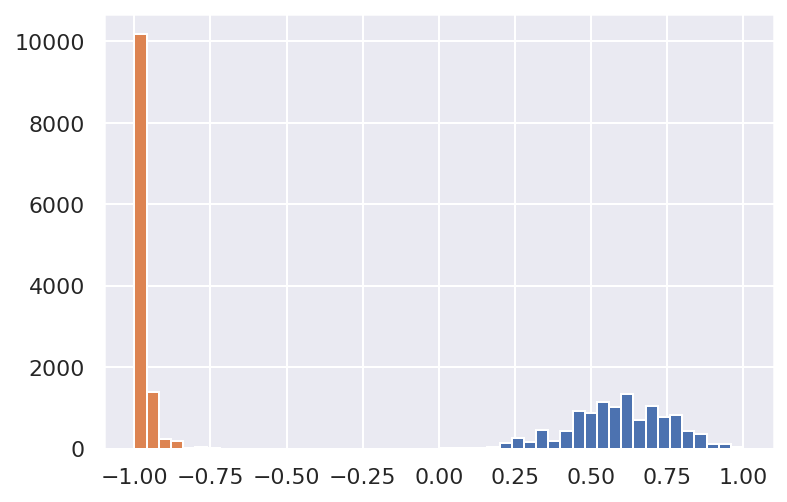

In [12]:
import matplotlib.pyplot as plt

select_feature = 0
_ = plt.hist(X_train_reshaped[:, 0, select_feature], bins=50)

select_feature = 8
_ = plt.hist(X_train_reshaped[:, 0, select_feature], bins=50)

In [13]:
model_params = {
    "artist": ARTIST,
    "rep": REP,
    "notes_window": NOTES_WINDOW,
    "chords_window": CHORDS_WINDOW,
    "pitches_per_chord": PITCHES_PER_CHORD, 
    "min_freq": MIN_FREQ,
    "unknown_tag": UNKNOWN,
    "train_split_train": train_idx_list,
    "train_split_validation": validation_idx_list,
    "train_select": TRAIN_SELECT,
    "test_select": TEST_SELECT,
    "most_common_pitches": Counter(y_train_raw_pitches).most_common(10),
    "most_common_durations": Counter(y_train_raw_durations).most_common(10),
    "mode": MODE,
    "minmax_scale": MINMAX_SCALE
}
with open(os.path.join(model_dir, "model_config.json"),'w') as fh:
    json.dump(model_params, fh)

In [ ]:
from keras import backend as K

EPOCHS=500
SONGS_STEP=None
BATCH_SIZE=1

# LRS = [1e-1] * EPOCHS
# LRS = [1e-3] * 100 + [1e-5] * 900
# LRS = [1e-2]*50 + [1e-3] * 150 + [1e-4] * 150 +[1e-5]*150
LRS = [1e-5] * 100
EPOCHS = len(LRS)

train_size, val_size = len(train_idx_list), len(validation_idx_list)
tmp_losses = []
for e in range(EPOCHS):
    if len(loss_per_epoch["train"]["all"]) == 3725:
        break
        
    print(f"\n______ EPOCH {e} _______ \n")
    random.shuffle(train_idx_list)
#     opt.learning_rate.assign(LRS[e])
    K.set_value(model.optimizer.learning_rate, LRS[e])

    learning_rates.append(LRS[e])

    print("\n---- TRAIN ----")
    train_loss, train_loss_p, train_loss_d = 0.0, 0.0, 0.0
    tmp_loss = 0.0
    for i, s_idx in enumerate(train_idx_list):
        first, last, indices_cache = extract_first_last_by_song_idx(s_idx, row_to_song_idx_train, indices_cache=indices_cache)
        
        sample_song = X_train_reshaped[first:last+1, :, :]
        sample_y_p = y_train_pitches[first:last+1]
        sample_y_d = y_train_durations[first:last+1]
        
        model.reset_states()
        hist = model.fit(
            {"m_input": sample_song},
            {"pitch_out": sample_y_p, "duration_out": sample_y_d},
            shuffle=False,
            batch_size=1,
            verbose=(1 if SONGS_STEP and (i+1) % SONGS_STEP == 0 else 0)
        )
        train_loss += hist.history['loss'][-1]
        train_loss_p += hist.history['pitch_out_loss'][-1]
        train_loss_d += hist.history['duration_out_loss'][-1]
        
        tmp_loss += hist.history['loss'][-1]
        if SONGS_STEP and (i+1) % SONGS_STEP == 0:
            print(i+1, ". loss so far =", tmp_loss / (i+1))
            tmp_losses.append(tmp_loss / (i+1))

    train_loss /= train_size
    loss_per_epoch["train"]["all"].append(train_loss)
    loss_per_epoch["train"]["p"].append(train_loss_p / train_size)
    loss_per_epoch["train"]["d"].append(train_loss_d / train_size)
    print(loss_per_epoch["train"]["all"][-1], loss_per_epoch["train"]["p"][-1], loss_per_epoch["train"]["d"][-1])
    
    if train_loss < best_loss:
        print(f"Loss improved from {best_loss} to {train_loss}")
        best_loss = train_loss
        model.save(os.path.join(model_dir, "weights.hdf5"))
        
    # SAVE LOSS
    with open(os.path.join(model_dir, "loss.json"), "w") as handle:
        json.dump(loss_per_epoch, handle)
        
    print("\n---- VALIDATION ----")
    validation_loss, validation_loss_p, validation_loss_d = 0.0, 0.0, 0.0
    for i, s_idx in enumerate(validation_idx_list):
        first, last, indices_cache = extract_first_last_by_song_idx(s_idx, row_to_song_idx_train, indices_cache=indices_cache)
        
        sample_song = X_train_reshaped[first:last+1, :, :]
        sample_y_p = y_train_pitches[first:last+1]
        sample_y_d = y_train_durations[first:last+1]

        model.reset_states()
        loss, loss_p, loss_d = model.evaluate(
            {"m_input": sample_song},
            {"pitch_out": sample_y_p, "duration_out": sample_y_d},
            batch_size=1,
            verbose=0
        )
        validation_loss += loss
        validation_loss_p += loss_p
        validation_loss_d += loss_d
        
    loss_per_epoch["val"]["all"].append(validation_loss / val_size)
    loss_per_epoch["val"]["p"].append(validation_loss_p / val_size)
    loss_per_epoch["val"]["d"].append(validation_loss_d / val_size)
    print(loss_per_epoch["val"]["all"][-1], loss_per_epoch["val"]["p"][-1], loss_per_epoch["val"]["d"][-1])


______ EPOCH 0 _______ 


---- TRAIN ----
6.014617089069251 3.4949692836915602 2.519647958302739
Loss improved from 6.015962364697697 to 6.014617089069251

---- VALIDATION ----
6.429549347270619 3.6659962263974277 2.7635531425476074

______ EPOCH 1 _______ 


---- TRAIN ----
6.013539834456011 3.494394788838396 2.51914518650132
Loss improved from 6.014617089069251 to 6.013539834456011

---- VALIDATION ----
6.4142397317019375 3.6587145653637974 2.7555256106636743

______ EPOCH 2 _______ 


---- TRAIN ----
6.013278698680376 3.493826980542655 2.519451769915494
Loss improved from 6.013539834456011 to 6.013278698680376

---- VALIDATION ----
6.432075088674372 3.661469903859225 2.770605271512812

______ EPOCH 3 _______ 


---- TRAIN ----
6.013352651788731 3.493613188916987 2.5197394881585633

---- VALIDATION ----
6.411140246824785 3.665501421148127 2.7456388906999067

______ EPOCH 4 _______ 


---- TRAIN ----
6.01882763101597 3.4947958269504587 2.524031893171445

---- VALIDATION ----
6.413752

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Serif'

PLOT_EPOCHS_NUM = 3000
plt.figure(figsize=(10, 5))

plt.plot(loss_per_epoch["train"]["all"][:PLOT_EPOCHS_NUM], label="train_loss", c='g')
plt.plot(loss_per_epoch["val"]["all"][:PLOT_EPOCHS_NUM], label="validation_loss", c='purple', alpha=0.5)
plt.legend(loc='center right')

plt.title(f"{model_name.replace('_', ' - ').replace('-NEW', '')}")
# plt.title("Basic LSTM training (128) - Abba's songs\nSummary loss")
plt.xlabel("epochs")
plt.ylabel("loss (pitch + duration)")

# MAKE SURE ITS SAVED!
model.save(os.path.join(model_dir, f'weights_{len(loss_per_epoch["train"]["all"])}.hdf5'))
with open(os.path.join(model_dir, "lrs.json"), "w") as handle:
    json.dump(learning_rates, handle)
with open(os.path.join(model_dir, "loss.json"), "w") as handle:
    json.dump(loss_per_epoch, handle)
    
plt.savefig(os.path.join(model_dir, "training.png"))
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(loss_per_epoch["train"]["p"][:PLOT_EPOCHS_NUM], label="train_loss_pitch")
plt.plot(loss_per_epoch["train"]["d"][:PLOT_EPOCHS_NUM], label="train_loss_duration")

plt.plot(loss_per_epoch["val"]["p"][:PLOT_EPOCHS_NUM], label="validation_loss_pitch")
plt.plot(loss_per_epoch["val"]["d"][:PLOT_EPOCHS_NUM], label="validation_loss_duration")

plt.legend(loc='center left')
# plt.title("Basic LSTM training (128) - Abba's songs\nSeparate loss for pitch and duration prediction")
plt.title(f"{model_name.replace('_', ' - ').replace('-NEW', '')}")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.savefig(os.path.join(model_dir, "training_pd.png"))
plt.show()

In [ ]:
model.save(os.path.join(model_dir, f'weights_{len(loss_per_epoch["train"]["all"])}.hdf5'))

In [19]:
with open(os.path.join(model_dir, "loss.json"), "r") as handle:
    loss_per_epoch = json.load(handle)
    
# for t in loss_per_epoch:
#     for tt in loss_per_epoch[t]:
#         loss_per_epoch[t][tt] = loss_per_epoch[t][tt][:300]

len(loss_per_epoch["train"]["all"])
model.load_weights(os.path.join(model_dir, f'weights_{len(loss_per_epoch["train"]["all"])}.hdf5'))
len(loss_per_epoch["train"]["all"])

300